#### installation and import

In [ ]:
!pip install wordcloud --quiet

In [ ]:
!pip install geopandas matplotlib --queit


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --queit


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from collections import Counter
import re

import geopandas as gpd

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from pyproj import Transformer

from sklearn.linear_model import LinearRegression

#### load dataset

In [ ]:
order_df = pd.read_csv('/content/drive/MyDrive/BITAmin/25-여름/프로젝트/data/olist_orders_dataset.csv') # 주문

print(f'주문 데이터 개수: {len(order_df)}')
order_df.head(1)

주문 데이터 개수: 99441


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00


In [ ]:
print(order_df['order_id'].nunique())
print(order_df['customer_id'].nunique())

99441
99441


### preprocessing

< Shipping & Delivery process >

주문 완료(order_purchase_timestamp) -> 결제 승인(order_approved_at)  
-> 물류 전달(order_delivered_carrier_date) -> 고객 수령(order_delivered_customer_date)

In [ ]:
order_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [ ]:
# check Null value
order_df[order_df['order_approved_at'].isnull()] # 결제 승인의 null 값은 분석에 영향을 미치지 않으므로 유지

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
1130,00b1cb0320190ca0daa2c88b35206009,3532ba38a3fd242259a514ac2b6ae6b6,canceled,2018-08-28 15:26:39,NaN,NaN,NaN,2018-09-12 00:00:00
1801,ed3efbd3a87bea76c2812c66a0b32219,191984a8ba4cbb2145acb4fe35b69664,canceled,2018-09-20 13:54:16,NaN,NaN,NaN,2018-10-17 00:00:00
1868,df8282afe61008dc26c6c31011474d02,aa797b187b5466bc6925aaaa4bb3bed1,canceled,2017-03-04 12:14:30,NaN,NaN,NaN,2017-04-10 00:00:00
2029,8d4c637f1accf7a88a4555f02741e606,b1dd715db389a2077f43174e7a675d07,canceled,2018-08-29 16:27:49,NaN,NaN,NaN,2018-09-13 00:00:00
2161,7a9d4c7f9b068337875b95465330f2fc,7f71ae48074c0cfec9195f88fcbfac55,canceled,2017-05-01 16:12:39,NaN,NaN,NaN,2017-05-30 00:00:00
...,...,...,...,...,...,...,...,...
97696,5a00b4d35edffc56b825c3646a99ba9d,6a3bdf004ca96338fb5fad1b8d93c2e6,canceled,2017-07-02 15:38:46,NaN,NaN,NaN,2017-07-25 00:00:00
98415,227c804e2a44760671a6a5697ea549e4,62e7477e75e542243ee62a0ba73f410f,canceled,2017-09-28 15:02:56,NaN,NaN,NaN,2017-10-16 00:00:00
98909,e49e7ce1471b4693482d40c2bd3ad196,e4e7ab3f449aeb401f0216f86c2104db,canceled,2018-08-07 11:16:28,NaN,NaN,NaN,2018-08-10 00:00:00
99283,3a3cddda5a7c27851bd96c3313412840,0b0d6095c5555fe083844281f6b093bb,canceled,2018-08-31 16:13:44,NaN,NaN,NaN,2018-10-01 00:00:00


In [ ]:
# check Null value
order_df[order_df['order_delivered_carrier_date'].isnull()] # 물류 전달일이 없으므로 drop

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaN,NaN,2017-05-09 00:00:00
103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaN,NaN,2018-08-21 00:00:00
128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaN,NaN,2017-10-03 00:00:00
266,8e24261a7e58791d10cb1bf9da94df5c,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,2017-11-16 15:26:57,NaN,NaN,2017-12-05 00:00:00
324,d3c8851a6651eeff2f73b0e011ac45d0,957f8e082185574de25992dc659ebbc0,processing,2016-10-05 22:44:13,2016-10-06 15:51:05,NaN,NaN,2016-12-09 00:00:00
...,...,...,...,...,...,...,...,...
99283,3a3cddda5a7c27851bd96c3313412840,0b0d6095c5555fe083844281f6b093bb,canceled,2018-08-31 16:13:44,NaN,NaN,NaN,2018-10-01 00:00:00
99313,e9e64a17afa9653aacf2616d94c005b8,b4cd0522e632e481f8eaf766a2646e86,processing,2018-01-05 23:07:24,2018-01-09 07:18:05,NaN,NaN,2018-02-06 00:00:00
99347,a89abace0dcc01eeb267a9660b5ac126,2f0524a7b1b3845a1a57fcf3910c4333,canceled,2018-09-06 18:45:47,NaN,NaN,NaN,2018-09-27 00:00:00
99348,a69ba794cc7deb415c3e15a0a3877e69,726f0894b5becdf952ea537d5266e543,unavailable,2017-08-23 16:28:04,2017-08-28 15:44:47,NaN,NaN,2017-09-15 00:00:00


In [ ]:
# check Null value
order_df[order_df['order_delivered_customer_date'].isnull()] # 고객 수령일이 없으므로 drop

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaN,NaN,2017-05-09 00:00:00
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaN,2018-06-28 00:00:00
103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaN,NaN,2018-08-21 00:00:00
128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaN,NaN,2017-10-03 00:00:00
154,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaN,2018-02-07 00:00:00
...,...,...,...,...,...,...,...,...
99283,3a3cddda5a7c27851bd96c3313412840,0b0d6095c5555fe083844281f6b093bb,canceled,2018-08-31 16:13:44,NaN,NaN,NaN,2018-10-01 00:00:00
99313,e9e64a17afa9653aacf2616d94c005b8,b4cd0522e632e481f8eaf766a2646e86,processing,2018-01-05 23:07:24,2018-01-09 07:18:05,NaN,NaN,2018-02-06 00:00:00
99347,a89abace0dcc01eeb267a9660b5ac126,2f0524a7b1b3845a1a57fcf3910c4333,canceled,2018-09-06 18:45:47,NaN,NaN,NaN,2018-09-27 00:00:00
99348,a69ba794cc7deb415c3e15a0a3877e69,726f0894b5becdf952ea537d5266e543,unavailable,2017-08-23 16:28:04,2017-08-28 15:44:47,NaN,NaN,2017-09-15 00:00:00


In [ ]:
# drop NaN value

order_df = order_df.dropna(subset=['order_delivered_carrier_date','order_delivered_customer_date'])

# 결과 확인
print(order_df.info()) # order_approved_at의 14개를 제외하고 모두 non-null

<class 'pandas.core.frame.DataFrame'>
Index: 96475 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       96475 non-null  object
 1   customer_id                    96475 non-null  object
 2   order_status                   96475 non-null  object
 3   order_purchase_timestamp       96475 non-null  object
 4   order_approved_at              96461 non-null  object
 5   order_delivered_carrier_date   96475 non-null  object
 6   order_delivered_customer_date  96475 non-null  object
 7   order_estimated_delivery_date  96475 non-null  object
dtypes: object(8)
memory usage: 6.6+ MB
None


In [ ]:
# change Data types (object -> datetime)

# datetime으로 변환할 컬럼들 지정
datetime_columns = [
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date'
]

# 각 컬럼을 datetime 형식으로 변환
for col in datetime_columns:
    order_df[col] = pd.to_datetime(order_df[col], errors='coerce')

# 결과 확인
print(order_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 96475 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       96475 non-null  object        
 1   customer_id                    96475 non-null  object        
 2   order_status                   96475 non-null  object        
 3   order_purchase_timestamp       96475 non-null  datetime64[ns]
 4   order_approved_at              96461 non-null  datetime64[ns]
 5   order_delivered_carrier_date   96475 non-null  datetime64[ns]
 6   order_delivered_customer_date  96475 non-null  datetime64[ns]
 7   order_estimated_delivery_date  96475 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.6+ MB
None


In [ ]:
for col in datetime_columns:
    print(f"NaT 개수 in {col}: {order_df[col].isnull().sum()}") # order_approved_at의 NaN만 NaT로 바뀜

NaT 개수 in order_purchase_timestamp: 0
NaT 개수 in order_approved_at: 14
NaT 개수 in order_delivered_carrier_date: 0
NaT 개수 in order_delivered_customer_date: 0
NaT 개수 in order_estimated_delivery_date: 0


#### Merge Data

In [ ]:
# orders_dataset & customers_dataset

customer_df = pd.read_csv('/content/drive/MyDrive/BITAmin/25-여름/프로젝트/data/olist_customers_dataset.csv') # 주문

print(f'주문 데이터 개수: {len(customer_df)}')
customer_df.head(1)

주문 데이터 개수: 99441


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP


In [ ]:
orders_with_customers = pd.merge(order_df, customer_df, on='customer_id', how='left')

print(f'주문 & 고객 데이터 개수: {len(customer_df)}')
orders_with_customers.head(1)

주문 & 고객 데이터 개수: 99441


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP


In [ ]:
# orders_dataset & customers_dataset + geolocation_dataset

geolocation_df = pd.read_csv('/content/drive/MyDrive/BITAmin/25-여름/프로젝트/data/olist_geolocation_dataset.csv') # 위치 데이터

print(f'위치 데이터 개수: {len(geolocation_df)}')
geolocation_df[geolocation_df['geolocation_zip_code_prefix']==24220][['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng']].describe()

위치 데이터 개수: 1000163


,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng
count,1146.0,1146.000000,1146.000000
mean,24220.0,-22.903245,-43.107024
std,0.0,0.002605,0.005132
min,24220.0,-22.910523,-43.115982
25%,24220.0,-22.904961,-43.111609
50%,24220.0,-22.903166,-43.107131
75%,24220.0,-22.901435,-43.102933
max,24220.0,-22.898404,-43.092417


In [ ]:
# 그룹별 대표값 계산
geolocation_df = geolocation_df.groupby('geolocation_zip_code_prefix').agg({
    'geolocation_lat': 'mean',
    'geolocation_lng': 'mean',
    'geolocation_city': 'first', # 첫 번째 값 선택
    'geolocation_state': 'first'
}).reset_index()

print(len(geolocation_df))
geolocation_df.head()

19015


,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1001,-23.550190,-46.634024,sao paulo,SP
1,1002,-23.548146,-46.634979,sao paulo,SP
2,1003,-23.548994,-46.635731,sao paulo,SP
3,1004,-23.549799,-46.634757,sao paulo,SP
4,1005,-23.549456,-46.636733,sao paulo,SP


In [ ]:
print(f'주문 & 고객 데이터 개수: {len(customer_df)}')
orders_with_customers.head(1)

주문 & 고객 데이터 개수: 99441


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP


In [ ]:
# order_df, customer_df, geolocation_df 병합 - left join
order_customer_geo_df = pd.merge(
    orders_with_customers,
    geolocation_df,
    left_on='customer_zip_code_prefix',
    right_on='geolocation_zip_code_prefix',
    how='left'
)

print(len(order_customer_geo_df))
order_customer_geo_df.head(1) # merge의 카르테시안 곱: 중복된 행을 제거하는 후속 연산 적용

96475


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,3149.0,-23.576983,-46.587161,sao paulo,SP


In [ ]:
# drop NaN value
order_customer_geo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96475 entries, 0 to 96474
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       96475 non-null  object        
 1   customer_id                    96475 non-null  object        
 2   order_status                   96475 non-null  object        
 3   order_purchase_timestamp       96475 non-null  datetime64[ns]
 4   order_approved_at              96461 non-null  datetime64[ns]
 5   order_delivered_carrier_date   96475 non-null  datetime64[ns]
 6   order_delivered_customer_date  96475 non-null  datetime64[ns]
 7   order_estimated_delivery_date  96475 non-null  datetime64[ns]
 8   customer_unique_id             96475 non-null  object        
 9   customer_zip_code_prefix       96475 non-null  int64         
 10  customer_city                  96475 non-null  object        
 11  customer_state 

In [ ]:
order_customer_geo_df = order_customer_geo_df.dropna(subset=['geolocation_zip_code_prefix'])

# 결과 확인
print(order_customer_geo_df.info()) # order_approved_at의 14개를 제외하고 모두 non-null

<class 'pandas.core.frame.DataFrame'>
Index: 96211 entries, 0 to 96474
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       96211 non-null  object        
 1   customer_id                    96211 non-null  object        
 2   order_status                   96211 non-null  object        
 3   order_purchase_timestamp       96211 non-null  datetime64[ns]
 4   order_approved_at              96197 non-null  datetime64[ns]
 5   order_delivered_carrier_date   96211 non-null  datetime64[ns]
 6   order_delivered_customer_date  96211 non-null  datetime64[ns]
 7   order_estimated_delivery_date  96211 non-null  datetime64[ns]
 8   customer_unique_id             96211 non-null  object        
 9   customer_zip_code_prefix       96211 non-null  int64         
 10  customer_city                  96211 non-null  object        
 11  customer_state      

#### Feature Engineering
주문 완료(order_purchase_timestamp) -> 결제 승인(order_approved_at)  
-> 물류 전달(order_delivered_carrier_date) -> 고객 수령(order_delivered_customer_date)

- delivery_time_days(배송시간: 주문완료 -> 고객수령)
- purchase_to_approval(결제 소요 시간: 주문완료 -> 결제승인)
- approval_to_carrier(물류 전달 소요시간: 결제승인 -> 물류전달)
- carrier_to_customer(고객 수령 소요시간: 물류전달 -> 고객수령)

In [ ]:
order_customer_geo_df['delivery_time_days'] = (order_customer_geo_df['order_delivered_customer_date']
                                               - order_customer_geo_df['order_purchase_timestamp']).dt.days

# 각 과정에서 소요 시간을 계산(시간 단위)
order_customer_geo_df['purchase_to_approval'] = (order_customer_geo_df['order_approved_at'] - order_customer_geo_df['order_purchase_timestamp']).dt.total_seconds() / 3600
order_customer_geo_df['approval_to_carrier'] = (order_customer_geo_df['order_delivered_carrier_date'] - order_customer_geo_df['order_approved_at']).dt.total_seconds() / 3600
order_customer_geo_df['carrier_to_customer'] = (order_customer_geo_df['order_delivered_customer_date'] - order_customer_geo_df['order_delivered_carrier_date']).dt.total_seconds() / 3600


### EDA

#### 1. 주 별 평균 배송시간

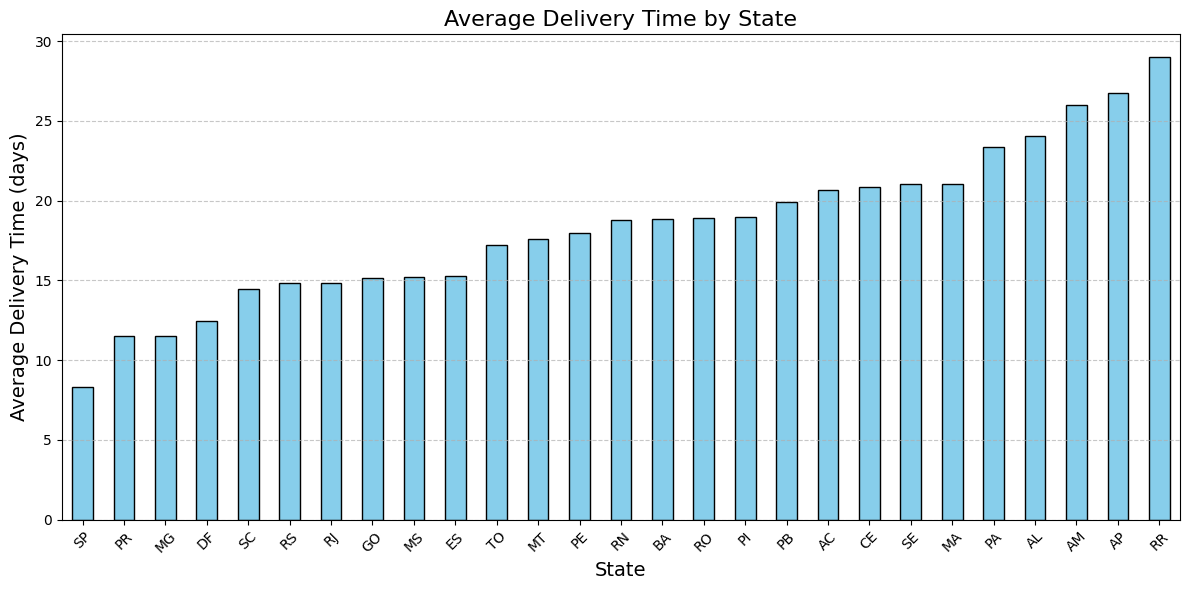

In [ ]:
state_delivery_times = order_customer_geo_df.groupby('customer_state')['delivery_time_days'].mean().sort_values()

plt.figure(figsize=(12, 6))
state_delivery_times.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Average Delivery Time by State', fontsize=16)
plt.ylabel('Average Delivery Time (days)', fontsize=14)
plt.xlabel('State', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### 2. 주 별 주문량

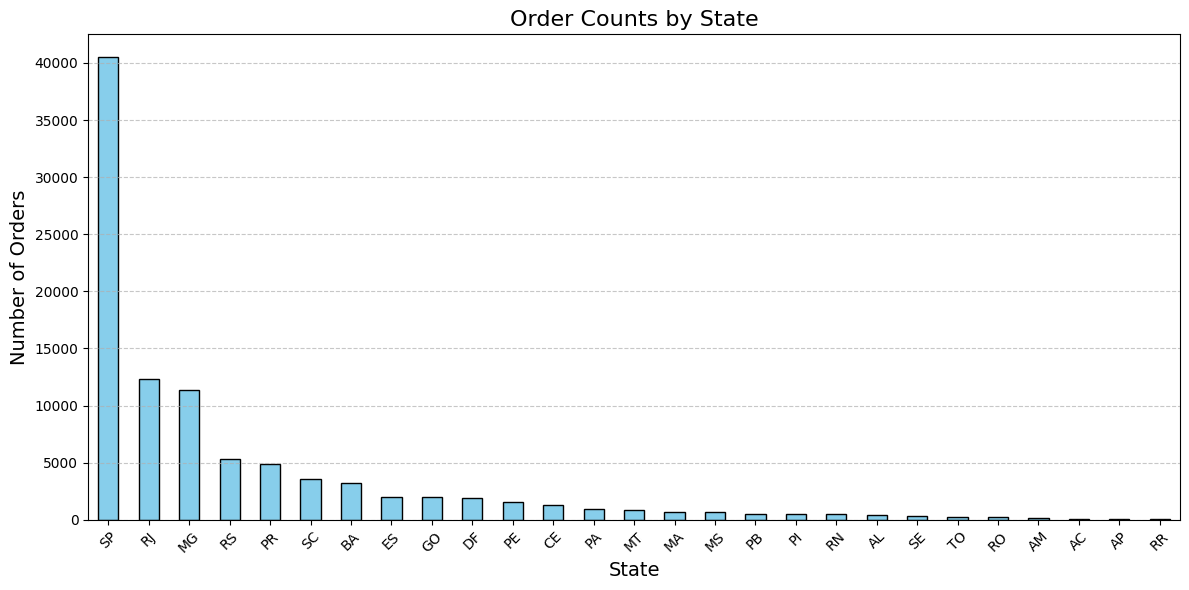

In [ ]:
state_order_counts = order_customer_geo_df.groupby('customer_state')['order_id'].count().sort_values(ascending=False)

state_order_counts.plot(kind='bar', figsize=(12, 6), color='skyblue', edgecolor='black')
plt.title('Order Counts by State', fontsize=16)
plt.ylabel('Number of Orders', fontsize=14)
plt.xlabel('State', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


#### 3. 배송 소요 과정 세분화
- 주문부터 고객에게 배송하기까지 단계별로 얼마나 걸리는지 시각화

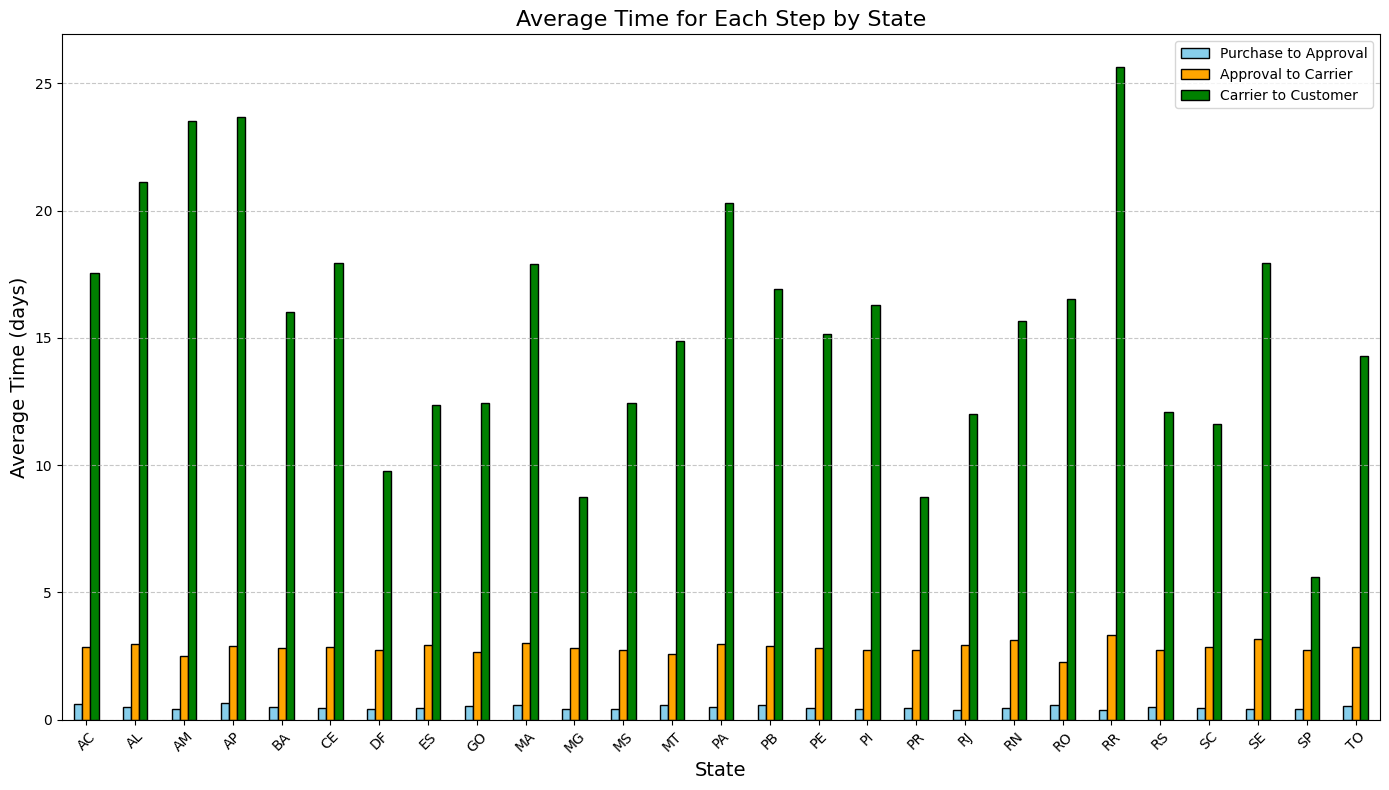

In [ ]:
# 시간(시간 단위)을 일(day) 단위로 변환
order_customer_geo_df['purchase_to_approval_days'] = order_customer_geo_df['purchase_to_approval'] / 24
order_customer_geo_df['approval_to_carrier_days'] = order_customer_geo_df['approval_to_carrier'] / 24
order_customer_geo_df['carrier_to_customer_days'] = order_customer_geo_df['carrier_to_customer'] / 24

# 주(State)별 평균 소요 시간 계산
state_times = order_customer_geo_df.groupby('customer_state').agg(
    purchase_to_approval_avg=('purchase_to_approval_days', 'mean'),
    approval_to_carrier_avg=('approval_to_carrier_days', 'mean'),
    carrier_to_customer_avg=('carrier_to_customer_days', 'mean')
).sort_index()

# 시각화 (단계별 소요 시간 비교)
state_times.plot(kind='bar', figsize=(14, 8), color=['skyblue', 'orange', 'green'], edgecolor='black')
plt.title('Average Time for Each Step by State', fontsize=16)
plt.ylabel('Average Time (days)', fontsize=14)
plt.xlabel('State', fontsize=14)
plt.xticks(rotation=45)
plt.legend(['Purchase to Approval', 'Approval to Carrier', 'Carrier to Customer'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### 4. 판매자 지역별 평균 배송 기간

In [ ]:
seller_df = pd.read_csv('/content/drive/MyDrive/BITAmin/25-여름/프로젝트/data/olist_sellers_dataset.csv') # 판매자 데이터

print(f'고객 데이터 개수: {len(seller_df)}')
seller_df.head(1)

고객 데이터 개수: 3095


,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP


In [ ]:
order_items_df = pd.read_csv('/content/drive/MyDrive/BITAmin/25-여름/프로젝트/data/olist_order_items_dataset.csv') # 판매자 데이터

print(f'주문 상세 데이터 개수: {len(order_items_df)}') # seller_id 때문에 order_items df가 필요
order_items_df.head(1)

주문 상세 데이터 개수: 112650


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29


In [ ]:
# 주문 상세 데이터와 판매자 데이터 병합
order_items_with_sellers = pd.merge(order_items_df, seller_df, on='seller_id', how='left')

print(len(order_items_with_sellers))
order_items_with_sellers.head(1)

112650


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,seller_zip_code_prefix,seller_city,seller_state
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,27277,volta redonda,SP


In [ ]:
# example
order_items_with_sellers[order_items_with_sellers['order_id']=='cd51709c98c738351915f79c4318675e'] # 상품 7개 주문

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,seller_zip_code_prefix,seller_city,seller_state
90414,cd51709c98c738351915f79c4318675e,1,3bb3e5caf47c7e92ed97227247e942a8,7d456afc660226829370f3173d14520c,2018-02-05 16:31:18,320.0,25.69,8820,mogi das cruzes,SP
90415,cd51709c98c738351915f79c4318675e,2,e9b3cf27d68caa64832c4a7c460abcb9,7d456afc660226829370f3173d14520c,2018-02-05 16:31:18,160.0,33.02,8820,mogi das cruzes,SP
90416,cd51709c98c738351915f79c4318675e,3,3bb3e5caf47c7e92ed97227247e942a8,7d456afc660226829370f3173d14520c,2018-02-05 16:31:18,320.0,25.69,8820,mogi das cruzes,SP
90417,cd51709c98c738351915f79c4318675e,4,3ebbc0870d51b62783c45e0e61ccb78d,7d456afc660226829370f3173d14520c,2018-02-05 16:31:18,52.0,38.54,8820,mogi das cruzes,SP
90418,cd51709c98c738351915f79c4318675e,5,3ebbc0870d51b62783c45e0e61ccb78d,7d456afc660226829370f3173d14520c,2018-02-05 16:31:18,52.0,38.54,8820,mogi das cruzes,SP
90419,cd51709c98c738351915f79c4318675e,6,e9b3cf27d68caa64832c4a7c460abcb9,7d456afc660226829370f3173d14520c,2018-02-05 16:31:18,160.0,33.02,8820,mogi das cruzes,SP
90420,cd51709c98c738351915f79c4318675e,7,3ebbc0870d51b62783c45e0e61ccb78d,7d456afc660226829370f3173d14520c,2018-02-05 16:31:18,52.0,38.54,8820,mogi das cruzes,SP


In [ ]:
# order_id별 고유한 seller_id 개수 계산
seller_count_per_order = order_items_with_sellers.groupby('order_id')['seller_id'].nunique()

# seller_id가 2개 이상인 order_id 필터링
multiple_sellers = seller_count_per_order[seller_count_per_order > 1]

# 결과 출력
print(f"seller_id가 2개 이상인 order_id 개수: {len(multiple_sellers)}")
print(multiple_sellers.head())  # 일부 결과 확인

seller_id가 2개 이상인 order_id 개수: 1278
order_id
002f98c0f7efd42638ed6100ca699b42    2
00bcee890eba57a9767c7b5ca12d3a1b    2
01144cadcf64b6427f0a6580a3033220    2
013a98b3a668bcef05b98898177f6923    2
014405982914c2cde2796ddcf0b8703d    2
Name: seller_id, dtype: int64


In [ ]:
# order_id와 seller_id의 조합 기준으로 중복 제거
orders_with_sellers_unique = order_items_with_sellers.drop_duplicates(subset=['order_id', 'seller_id'])

# 결과 확인
print(len(orders_with_sellers_unique))
orders_with_sellers_unique.head()


100010


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,seller_zip_code_prefix,seller_city,seller_state
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,27277,volta redonda,SP
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,3471,sao paulo,SP
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,37564,borda da mata,MG
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,14403,franca,SP
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,87900,loanda,PR


In [ ]:
# example
orders_with_sellers_unique[orders_with_sellers_unique['order_id']=='cd51709c98c738351915f79c4318675e'] # 판매자가 같은 상품 7개 주문

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,seller_zip_code_prefix,seller_city,seller_state
90414,cd51709c98c738351915f79c4318675e,1,3bb3e5caf47c7e92ed97227247e942a8,7d456afc660226829370f3173d14520c,2018-02-05 16:31:18,320.0,25.69,8820,mogi das cruzes,SP


In [ ]:
orders_with_sellers_unique[orders_with_sellers_unique['order_id']=='002f98c0f7efd42638ed6100ca699b42'] # 판매자가 다른 2개의 상품 주문

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,seller_zip_code_prefix,seller_city,seller_state
80,002f98c0f7efd42638ed6100ca699b42,1,d41dc2f2979f52d75d78714b378d4068,7299e27ed73d2ad986de7f7c77d919fa,2017-08-10 09:30:15,8.99,32.57,38440,araguari,MG
81,002f98c0f7efd42638ed6100ca699b42,2,880be32f4db1d9f6e2bec38fb6ac23ab,fa40cc5b934574b62717c68f3d678b6d,2017-08-10 09:30:15,44.90,7.16,2310,sao paulo,SP


In [ ]:
# 주문 상세 + 판매자 데이터와 주문 데이터 병합하여 배송 정보 포함
orders_with_sellers = pd.merge(order_customer_geo_df, orders_with_sellers_unique, on='order_id', how='left')

print(len(orders_with_sellers))
orders_with_sellers.head(1)

97546


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,carrier_to_customer_days,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,seller_zip_code_prefix,seller_city,seller_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,6.06265,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,9350,maua,SP


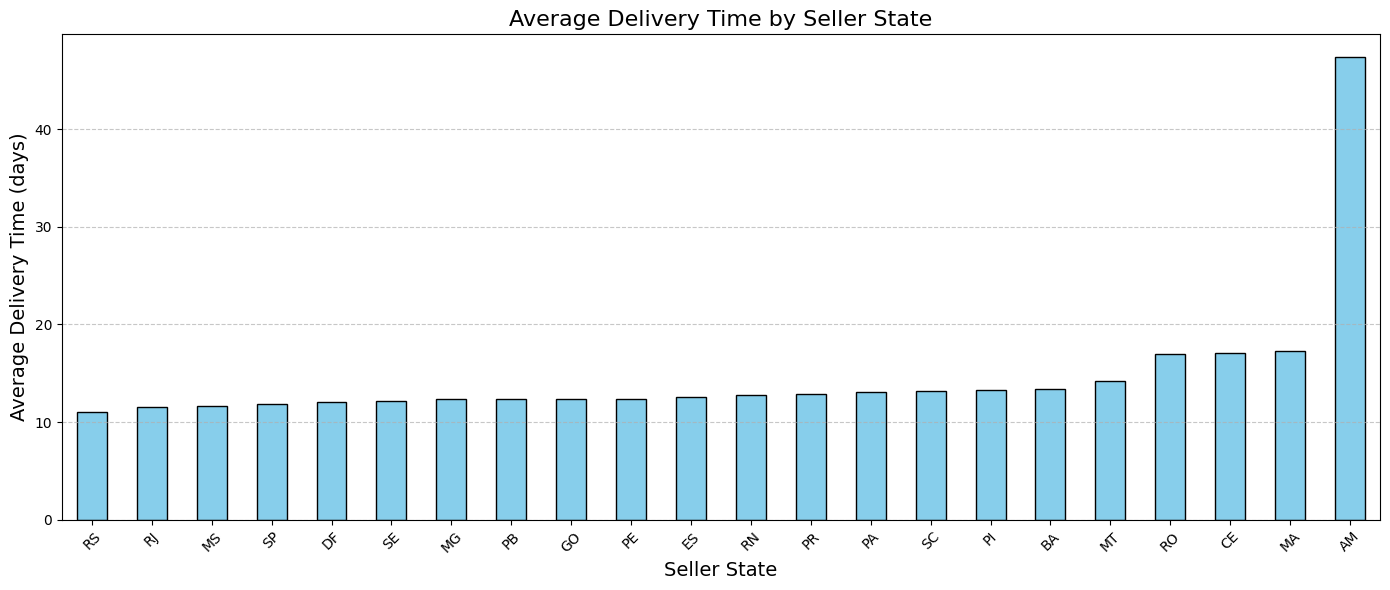

In [ ]:
# 판매자 지역(seller_state)별 평균 배송 기간 계산
seller_state_delivery = orders_with_sellers.groupby('seller_state')['delivery_time_days'].mean().sort_values()

plt.figure(figsize=(14, 6))
seller_state_delivery.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Average Delivery Time by Seller State', fontsize=16)
plt.xlabel('Seller State', fontsize=14)
plt.ylabel('Average Delivery Time (days)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### 5. 리뷰 데이터 분석

In [ ]:
review_df = pd.read_csv("/content/drive/MyDrive/BITAmin/25-여름/프로젝트/data/olist_order_reviews_dataset.csv") # 리뷰

print(f'리뷰 데이터 개수: {len(order_df)}')
review_df.head(1)

리뷰 데이터 개수: 96475


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59


In [ ]:
# 전처리 해둔 order_customer_geo_df와 review_df merge
order_customer_geo_review_df = pd.merge(order_customer_geo_df, review_df, on='order_id', how='left')

print(len(order_customer_geo_review_df))
order_customer_geo_review_df.head(1)

96737


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,carrier_to_customer,purchase_to_approval_days,approval_to_carrier_days,carrier_to_customer_days,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,145.503611,0.007431,2.366493,6.06265,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48


In [ ]:
# order_customer_geo_review_df와 order_items_df merge
order_customer_geo_review_df = pd.merge(order_customer_geo_review_df, order_items_df, on='order_id', how='left')

print(len(order_customer_geo_review_df))
order_customer_geo_review_df.head(1)

110545


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72


In [ ]:
order_customer_geo_review_df['freight_value']

,freight_value
0,8.72
1,22.76
2,19.22
3,27.20
4,8.72
...,...
110540,20.10
110541,65.02
110542,40.59
110543,40.59


In [ ]:
pd.cut(order_customer_geo_review_df['freight_value'], bins=5)

,freight_value
0,"(-0.41, 81.936]"
1,"(-0.41, 81.936]"
2,"(-0.41, 81.936]"
3,"(-0.41, 81.936]"
4,"(-0.41, 81.936]"
...,...
110540,"(-0.41, 81.936]"
110541,"(-0.41, 81.936]"
110542,"(-0.41, 81.936]"
110543,"(-0.41, 81.936]"


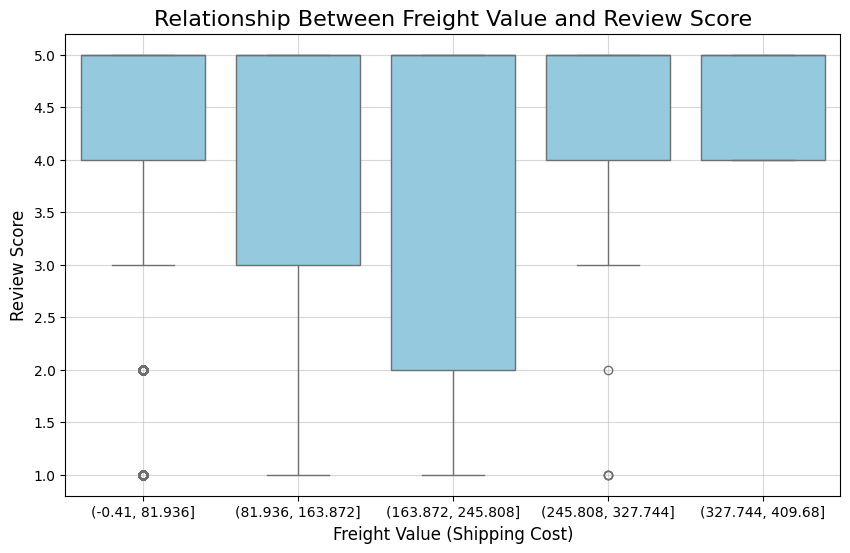

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=order_customer_geo_review_df,
    x=pd.cut(order_customer_geo_review_df['freight_value'], bins=5),
    y='review_score',
    color='skyblue'
)

plt.title('Relationship Between Freight Value and Review Score', fontsize=16)
plt.xlabel('Freight Value (Shipping Cost)', fontsize=12)
plt.ylabel('Review Score', fontsize=12)
plt.grid(alpha=0.5)
plt.show()

#### 6. 리뷰 키워드 추출

/tmp/ipython-input-1190074155.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_score_reviews['keywords'] = low_score_reviews['review_comment_message'].apply(lambda x: extract_keywords(x, keywords))


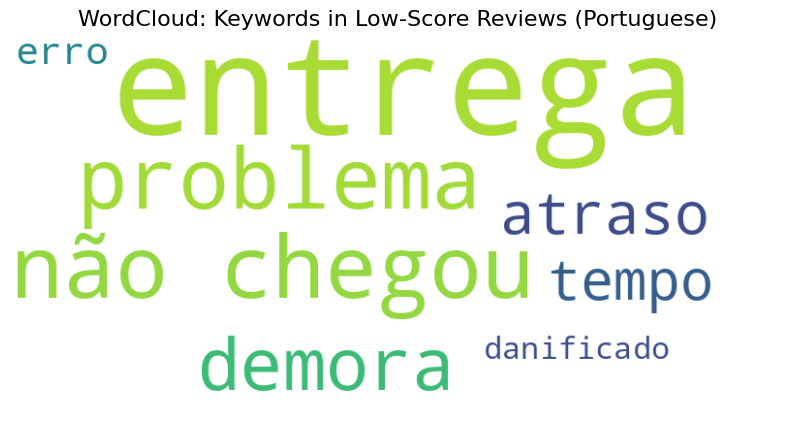

포르투갈어 배송 관련 키워드 빈도:
atraso: 184회
demora: 297회
entrega: 1872회
não chegou: 456회
erro: 66회
problema: 430회
tempo: 167회
danificado: 40회

낮은 점수 리뷰의 평균 배송 시간: 18.25일


In [ ]:
# 낮은 점수 리뷰 텍스트 분석 (포르투갈어 키워드 사용)

# 낮은 점수(1~2점) 리뷰 필터링
low_score_reviews = order_customer_geo_review_df[(order_customer_geo_review_df['review_score'] == 1) | (order_customer_geo_review_df['review_score'] == 2)]

# 포르투갈어 키워드 설정
keywords = ['atraso', 'demora', 'entrega', 'problema', 'erro', 'tempo', 'não chegou', 'danificado']

# 키워드 추출 함수
def extract_keywords(text, keyword_list):
    if pd.isna(text):
        return []
    return [word for word in keyword_list if word in text.lower()]

# 키워드 추출 및 빈도 계산
low_score_reviews['keywords'] = low_score_reviews['review_comment_message'].apply(lambda x: extract_keywords(x, keywords))
all_keywords = Counter([word for sublist in low_score_reviews['keywords'] for word in sublist])


# 키워드 시각화 (워드클라우드)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(all_keywords)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud: Keywords in Low-Score Reviews (Portuguese)', fontsize=16)
plt.show()


# 결과 요약
print("포르투갈어 배송 관련 키워드 빈도:")
for word, count in all_keywords.items():
    print(f"{word}: {count}회")


# 낮은 리뷰 점수와 평균 배송 시간 출력
avg_delivery_time_low_reviews = low_score_reviews['delivery_time_days'].mean()
print(f"\n낮은 점수 리뷰의 평균 배송 시간: {avg_delivery_time_low_reviews:.2f}일")


#### Solution: 배송기간을 줄여 고객 만족도를 높이기 위해 fulfillment 추가

In [ ]:
order_customer_geo_df.head(1)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,geolocation_lng,geolocation_city,geolocation_state,delivery_time_days,purchase_to_approval,approval_to_carrier,carrier_to_customer,purchase_to_approval_days,approval_to_carrier_days,carrier_to_customer_days
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,-46.587161,sao paulo,SP,8,0.178333,56.795833,145.503611,0.007431,2.366493,6.06265


In [ ]:
seller_df = pd.read_csv('/content/drive/MyDrive/BITAmin/25-여름/프로젝트/data/olist_sellers_dataset.csv') # 판매자 데이터
geolocation_df = pd.read_csv('/content/drive/MyDrive/BITAmin/25-여름/프로젝트/data/olist_geolocation_dataset.csv') # 위치 데이터

In [ ]:
geolocation_df = geolocation_df.groupby('geolocation_zip_code_prefix').agg({
    'geolocation_lat': 'mean',
    'geolocation_lng': 'mean',
    'geolocation_city': 'first', # 첫 번째 값 선택
    'geolocation_state': 'first'
}).reset_index()

print(len(geolocation_df))
geolocation_df.head()

19015


,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1001,-23.550190,-46.634024,sao paulo,SP
1,1002,-23.548146,-46.634979,sao paulo,SP
2,1003,-23.548994,-46.635731,sao paulo,SP
3,1004,-23.549799,-46.634757,sao paulo,SP
4,1005,-23.549456,-46.636733,sao paulo,SP


In [ ]:
# geolocation_df와 seller_df의 right join
geolocation_seller_df = pd.merge(
    geolocation_df,
    seller_df,
    left_on='geolocation_zip_code_prefix',
    right_on='seller_zip_code_prefix',
    how='right'
)

# select columns
geolocation_seller_df = geolocation_seller_df[['seller_id','geolocation_zip_code_prefix','geolocation_lat',
                                               'geolocation_lng','geolocation_city','geolocation_state']]
print(len(geolocation_seller_df))
geolocation_seller_df.head(1)

3095


,seller_id,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,3442f8959a84dea7ee197c632cb2df15,13023.0,-22.893848,-47.061337,campinas,SP


### visulization

#### 판매자 위치 정보

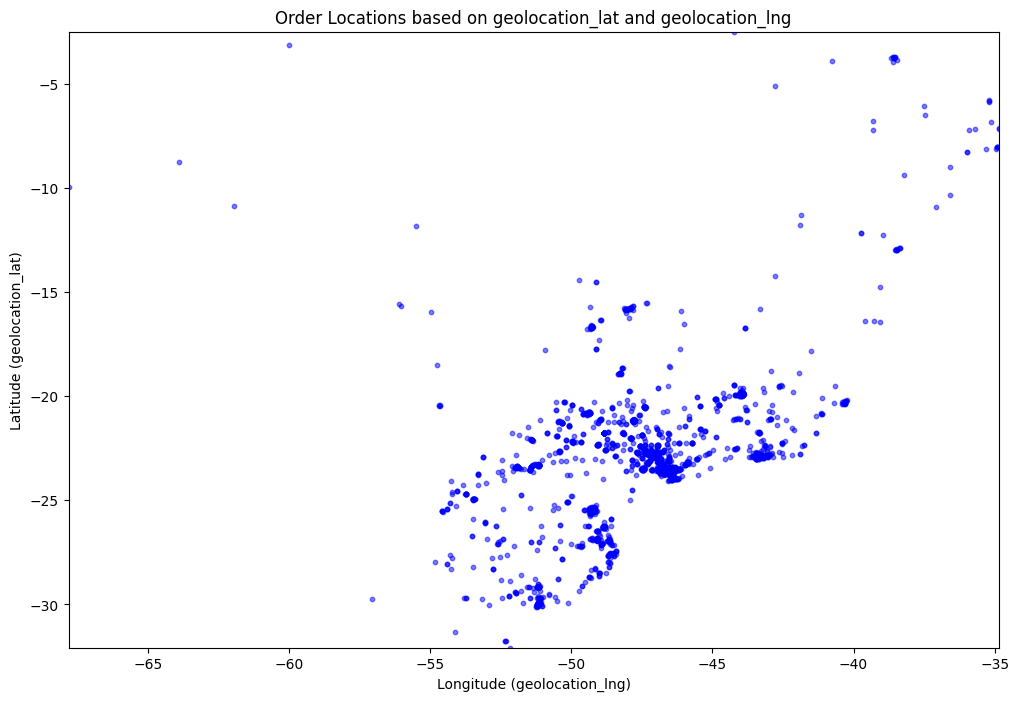

In [ ]:
# 각 order_id에 대한 geolocation_lat와 geolocation_lng 점 그리기
plt.figure(figsize=(12, 8))

# 산점도 생성
plt.scatter(geolocation_seller_df['geolocation_lng'], geolocation_seller_df['geolocation_lat'], c='blue', alpha=0.5, s=10)

# 제목과 라벨 추가
plt.title('Order Locations based on geolocation_lat and geolocation_lng')
plt.xlabel('Longitude (geolocation_lng)')
plt.ylabel('Latitude (geolocation_lat)')

# 최소/최대값을 평면에 적용
plt.xlim(geolocation_seller_df['geolocation_lng'].min(), geolocation_seller_df['geolocation_lng'].max())
plt.ylim(geolocation_seller_df['geolocation_lat'].min(), geolocation_seller_df['geolocation_lat'].max())

# 시각화 표시
plt.show()


#### 고객 위치 정보

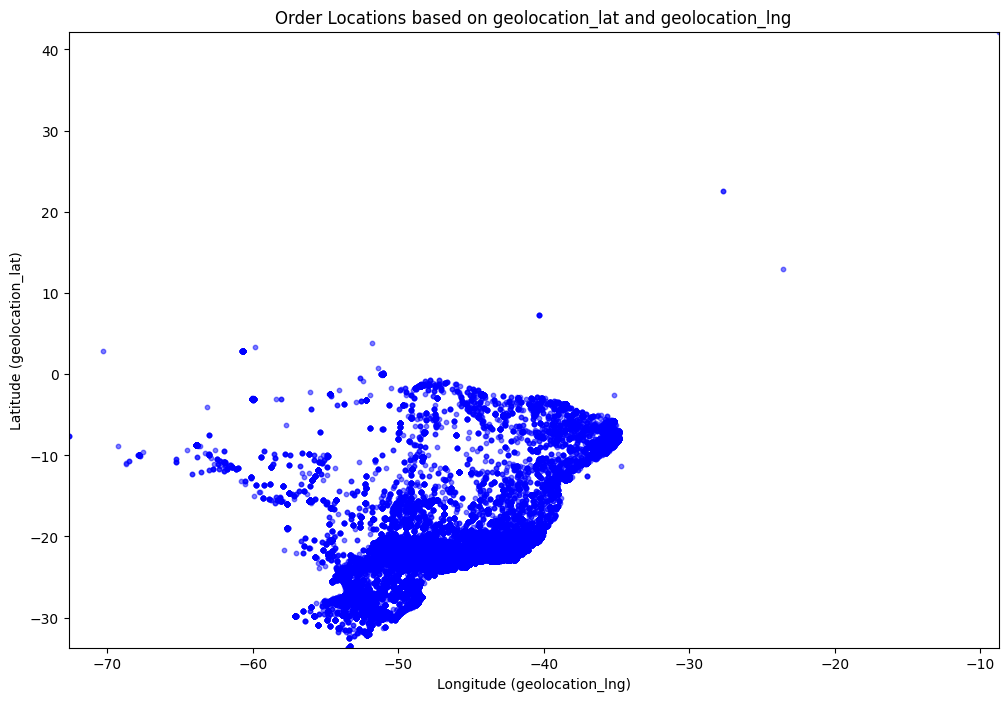

In [ ]:
# 각 order_id에 대한 geolocation_lat와 geolocation_lng 점 그리기
plt.figure(figsize=(12, 8))

# 산점도 생성
plt.scatter(order_customer_geo_df['geolocation_lng'], order_customer_geo_df['geolocation_lat'], c='blue', alpha=0.5, s=10)

# 제목과 라벨 추가
plt.title('Order Locations based on geolocation_lat and geolocation_lng')
plt.xlabel('Longitude (geolocation_lng)')
plt.ylabel('Latitude (geolocation_lat)')

# 최소/최대값을 평면에 적용
plt.xlim(order_customer_geo_df['geolocation_lng'].min(), order_customer_geo_df['geolocation_lng'].max())
plt.ylim(order_customer_geo_df['geolocation_lat'].min(), order_customer_geo_df['geolocation_lat'].max())

# 시각화 표시
plt.show()


#### 판매자 정보 지도 위에 표현

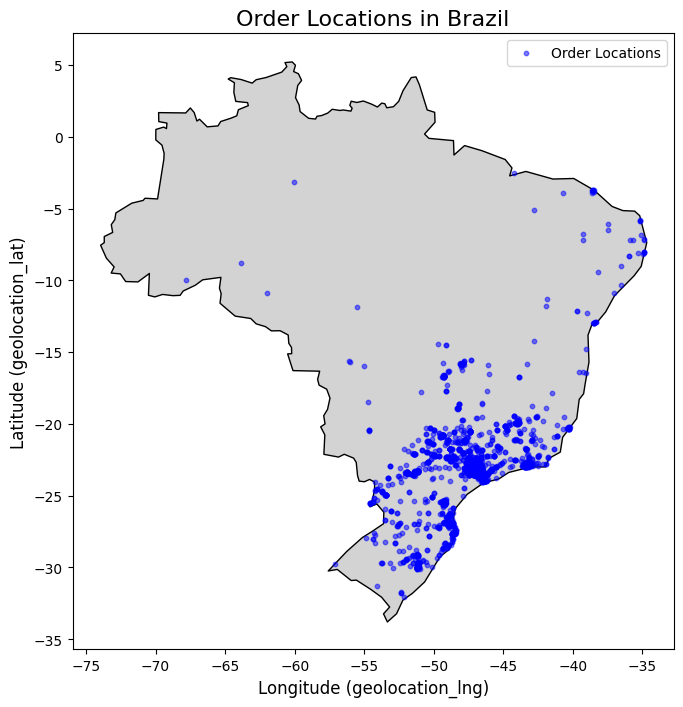

In [ ]:
# 파일 경로: 압축 해제 후 .shp 파일 경로 지정
shapefile_path = "/content/drive/MyDrive/BITAmin/25-여름/프로젝트/ne_100m_admin_0_countries/ne_110m_admin_0_countries.shp"

# GeoPandas로 데이터 로드
world = gpd.read_file(shapefile_path)
brazil = world[world['NAME'] == 'Brazil']  # NAME 대신 'name'으로 대소문자를 확인하세요.

# 기존 데이터: geolocation_seller_df
import pandas as pd

# 브라질 지도 그리기
fig, ax = plt.subplots(figsize=(12, 8))
brazil.plot(ax=ax, color='lightgray', edgecolor='black')

# 데이터 산점도 그리기
plt.scatter(
    geolocation_seller_df['geolocation_lng'],
    geolocation_seller_df['geolocation_lat'],
    c='blue',
    alpha=0.5,
    s=10,
    label='Order Locations'
)

# 제목과 축 설정
plt.title('Order Locations in Brazil', fontsize=16)
plt.xlabel('Longitude (geolocation_lng)', fontsize=12)
plt.ylabel('Latitude (geolocation_lat)', fontsize=12)

# 범례 추가
plt.legend()

# 시각화 표시
plt.show()

#### 고객 위치 지도 위에 표현

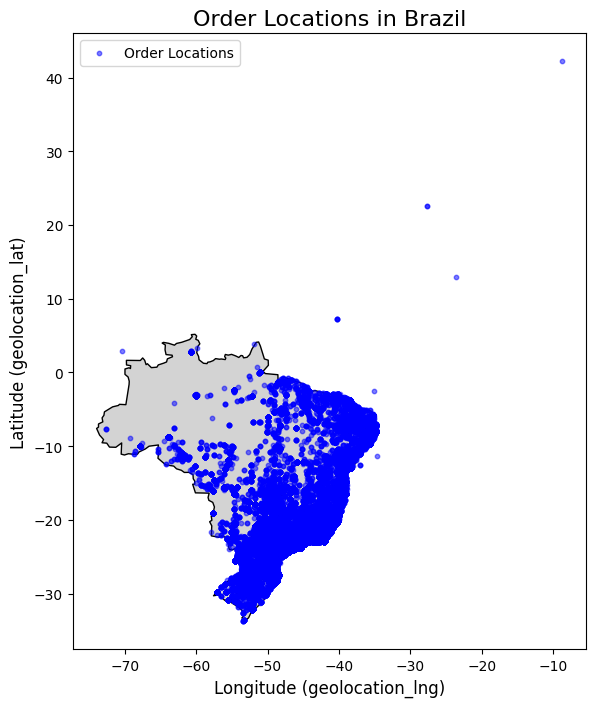

In [ ]:
# 파일 경로: 압축 해제 후 .shp 파일 경로 지정
shapefile_path = "/content/drive/MyDrive/BITAmin/25-여름/프로젝트/ne_100m_admin_0_countries/ne_110m_admin_0_countries.shp"

# GeoPandas로 데이터 로드
world = gpd.read_file(shapefile_path)
brazil = world[world['NAME'] == 'Brazil']  # NAME 대신 'name'으로 대소문자를 확인하세요.

# 기존 데이터: geolocation_seller_df
import pandas as pd

# 브라질 지도 그리기
fig, ax = plt.subplots(figsize=(12, 8))
brazil.plot(ax=ax, color='lightgray', edgecolor='black')

# 데이터 산점도 그리기
plt.scatter(
    order_customer_geo_df['geolocation_lng'],
    order_customer_geo_df['geolocation_lat'],
    c='blue',
    alpha=0.5,
    s=10,
    label='Order Locations'
)

# 제목과 축 설정
plt.title('Order Locations in Brazil', fontsize=16)
plt.xlabel('Longitude (geolocation_lng)', fontsize=12)
plt.ylabel('Latitude (geolocation_lat)', fontsize=12)

# 범례 추가
plt.legend()

# 시각화 표시
plt.show()

### K-means develop

In [ ]:
df = order_customer_geo_df.copy()

print(geolocation_seller_df.columns)
print(order_customer_geo_df.columns)
print(order_items_df.columns)

Index(['seller_id', 'geolocation_zip_code_prefix', 'geolocation_lat',
       'geolocation_lng', 'geolocation_city', 'geolocation_state'],
      dtype='object')
Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'geolocation_zip_code_prefix', 'geolocation_lat',
       'geolocation_lng', 'geolocation_city', 'geolocation_state',
       'delivery_time_days', 'purchase_to_approval', 'approval_to_carrier',
       'carrier_to_customer'],
      dtype='object')
Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')


기존 df에 seller 데이터 합치기  
이때, 한 주문당 여러 셀러가 포함되어 있는 경우에는 가장 큰 금액인 경우의 셀러로 선정

In [ ]:
# 주문+고객 좌표 복제본
df = order_customer_geo_df.copy()

# 주문-셀러별 금액 합계
#  - Olist는 한 주문에서 동일 셀러가 여러 item을 팔 수 있으므로 sum 필요
rev_by_seller = (
    order_items_df
    .groupby(['order_id', 'seller_id'], as_index=False)['price'].sum()
    .rename(columns={'price':'seller_revenue_in_order'})
)

# 주문별로 '금액 최대' 셀러 선택
idx = rev_by_seller.groupby('order_id')['seller_revenue_in_order'].idxmax()
order_seller_top = rev_by_seller.loc[idx, ['order_id','seller_id','seller_revenue_in_order']]

# 주문 테이블에 대표 셀러 붙이기
df = order_customer_geo_df.merge(order_seller_top, on='order_id', how='left')

# 셀러 좌표 붙이기
df = df.merge(
    geolocation_seller_df[['seller_id','geolocation_lat','geolocation_lng']],
    on='seller_id', how='left', suffixes=('_cust','_sell')
)

In [148]:
# 지연일수/정시여부/ZIP 평균 지연일수 생성
df['delay_days'] = (df['order_delivered_customer_date'] -
                    df['order_estimated_delivery_date']).dt.days
df['on_time_flag'] = (df['delay_days'] <= 0).astype(int)

avg_delay_zip = (
    df.groupby('customer_zip_code_prefix')['delay_days']
      .mean().rename('avg_delay')
      .reset_index()
)
df = df.merge(avg_delay_zip, on='customer_zip_code_prefix', how='left')

In [ ]:
# 1) 고객 포인트 + 수요 가중치
cust_pts = (
    df[['geolocation_lat_cust','geolocation_lng_cust']]
    .rename(columns={'geolocation_lat_cust':'lat','geolocation_lng_cust':'lng'})
    .copy()
)
# 수요 가중치: 일단 1로(원하면 zip별 주문수 등으로 대체)
cust_pts['w'] = 1.0

# 결측 좌표 제거
cust_pts = cust_pts.dropna(subset=['lat','lng'])


# 2) 셀러 포인트 + 공급 가중치(매출)
# 셀러 출고 매출 (order_items_df 필요)
seller_out_rev = (
    order_items_df.groupby('seller_id')['price'].sum()
    .rename('out_rev').reset_index()
)

seller_geo = (
    geolocation_seller_df[['seller_id','geolocation_lat','geolocation_lng']]
    .merge(seller_out_rev, on='seller_id', how='left')
    .rename(columns={'geolocation_lat':'lat','geolocation_lng':'lng'})
)

# out_rev가 NaN이면 0으로 (매출 기록 없는 셀러)
seller_geo['out_rev'] = seller_geo['out_rev'].fillna(0)

# 공급 가중치: 극단 완화용 sqrt
seller_geo['w'] = np.sqrt(seller_geo['out_rev'] + 1e-6)

# 좌표 결측 제거 + 가중치 0 제거
seller_geo = seller_geo.dropna(subset=['lat','lng','w'])
seller_geo = seller_geo[seller_geo['w'] > 0]


# 3) 고객/셀러 합치고 비율 조정(beta)
# beta = 0.5  # 고객:셀러 영향 ≈ 1:0.5 (원하면 조정)
stack = pd.concat([
    cust_pts[['lat','lng','w']],
    seller_geo[['lat','lng','w']].assign(w=lambda s: beta * s['w'])
], ignore_index=True)


# 4) 최종 방탄 전처리: 결측/비유한 제거, 좌표 범위 체크
# 좌표 합리 범위 필터 (브라질 대략 경위도 박스, 원하면 생략해도 됨)
# stack = stack[(stack['lng'] >= -75) & (stack['lng'] <= -32) &
#               (stack['lat'] >= -35) & (stack['lat'] <= 8)]

# # 결측/무한 제거
# mask_finite = np.isfinite(stack[['lat','lng','w']]).all(axis=1)
# stack = stack[mask_finite].copy()

# # 가중치 음수/0 제거
# stack = stack[stack['w'] > 0]

# # K가 포인트 수보다 크면 축소
# k = 5
# if len(stack) < k:
#     k = max(1, len(stack))
#     print(f"[경고] 유효 포인트가 적어 K를 {k}로 축소합니다.")


# # 5) K-means 학습 (표본가중치)
# X = stack[['lat','lng']].to_numpy()
# w = stack['w'].to_numpy()

# km = KMeans(n_clusters=k, random_state=42, n_init='auto')
# km.fit(X, sample_weight=w)

# centers = km.cluster_centers_  # (lat, lng)

# print(f"K={k}, 센터(위경도):")
# print(centers)

In [ ]:
def haversine_km(lat1,lng1,lat2,lng2):
    R = 6371.0088
    p1 = np.radians(lat1); p2 = np.radians(lat2)
    dlat = p2 - p1
    dlng = np.radians(lng2 - lng1)
    a = np.sin(dlat/2)**2 + np.cos(p1)*np.cos(p2)*np.sin(dlng/2)**2
    return 2*R*np.arcsin(np.sqrt(a))

# (A) 직배송 거리
df['dist_direct_km'] = haversine_km(df['geolocation_lat_cust'], df['geolocation_lng_cust'],
                                    df['geolocation_lat_sell'], df['geolocation_lng_sell'])

# (B) 센터 후보 선정: 고객 위치로 K-means (위경도 그대로 써도 되지만 왜곡 줄이려면 투영 권장)
transformer = Transformer.from_crs("EPSG:4326","EPSG:3857", always_xy=True)
x_m_c, y_m_c = transformer.transform(df['geolocation_lng_cust'].values, df['geolocation_lat_cust'].values)

k = 5  # 센터 개수
kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto").fit(np.c_[x_m_c, y_m_c])

# 센터를 위경도로 변환
inv = Transformer.from_crs("EPSG:3857","EPSG:4326", always_xy=True)
centers_lng, centers_lat = inv.transform(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1])
centers = np.c_[centers_lat, centers_lng]  # (lat, lng)

# 주문별 센터 경유 최단 합거리 = min( seller→center + center→customer )
d_total = []
for lat_s, lng_s, lat_c, lng_c in zip(df['geolocation_lat_sell'], df['geolocation_lng_sell'],
                                      df['geolocation_lat_cust'], df['geolocation_lng_cust']):
    d_s2centers = haversine_km(lat_s, lng_s, centers[:,0], centers[:,1])
    d_c2centers = haversine_km(lat_c, lng_c, centers[:,0], centers[:,1])
    d_total.append( (d_s2centers + d_c2centers).min() )

df['dist_center_km'] = d_total


In [152]:
def kpi_block(name, series):
    return {
        'scenario': name,
        'avg_dist_km': series.mean(),
        '≤200km_%': (series<=200).mean()*100,
        '≤500km_%': (series<=500).mean()*100,
        '≤2000km_%': (series<=2000).mean()*100,
        'n_orders': len(series)
    }

kpi = pd.DataFrame([
    kpi_block('Direct Seller→Customer', df['dist_direct_km']),
    kpi_block(f'{k} Fulfillment Centers', df['dist_center_km']),
])
print(kpi)

                 scenario  avg_dist_km   ≤200km_%   ≤500km_%  ≤2000km_%  \
0  Direct Seller→Customer   600.760750  25.603102  57.053767  93.945599   
1   5 Fulfillment Centers   779.165439   0.078993  34.873351  93.410317   

   n_orders  
0     96211  
1     96211  


코드 수정,,

- 직배송 기준선: 주문별 셀러→고객 거리(= 현재 모델)
- 센터 시나리오:
- 핵심 KPI는 라스트마일(센터→고객) 만 비교 👉 고객 체감/리드타임/배송비에 직결
- 인바운드(셀러→센터) 는 별도 대시보드로 기간 합계(톤·km) 를 관리 (주문 단위로 더하지 않기)

아래 코드 해석 :
- 단계 A: 센터 입지 선정 (가중치 KMeans 그대로 사용)
- 단계 B: 주문을 가까운 센터에 할당 → 라스트마일만 평균거리/커버리지 산출
- 단계 C: 인바운드(셀러→센터)는 주문 수량 기준으로 집계해 총 물동(거리×주문수)을 별도로 리포트

In [ ]:
# 가정: df 는 주문+고객좌표+대표 seller_id+셀러좌표가 붙어있음
#  - geolocation_lat_cust, geolocation_lng_cust
#  - geolocation_lat_sell, geolocation_lng_sell
# centers: 앞서 뽑은 센터 좌표 (shape = (K, 2): [lat, lng])

def haversine_km(lat1,lng1,lat2,lng2):
    R = 6371.0088
    p1 = np.radians(lat1); p2 = np.radians(lat2)
    dlat = p2 - p1
    dlng = np.radians(lng2 - lng1)
    a = np.sin(dlat/2)**2 + np.cos(p1)*np.cos(p2)*np.sin(dlng/2)**2
    return 2*R*np.arcsin(np.sqrt(a))

# A. 기준선: 현행 직배송 ---
df['dist_direct_km'] = haversine_km(
    df['geolocation_lat_cust'], df['geolocation_lng_cust'],
    df['geolocation_lat_sell'], df['geolocation_lng_sell']
)

# B. 센터 시나리오: 고객을 가장 가까운 센터에 할당 → 라스트마일만 평가 ---
cent_lat, cent_lng = centers[:,0], centers[:,1]
# 고객→각 센터 거리 행렬 (n_orders x K) 의 최소값이 라스트마일
d_c2cent = np.vstack([
    haversine_km(df['geolocation_lat_cust'], df['geolocation_lng_cust'], clat, clng)
    for clat, clng in zip(cent_lat, cent_lng)
]).T  # shape: (n_orders, K)

df['assigned_center_id'] = d_c2cent.argmin(axis=1)
df['lastmile_km'] = d_c2cent.min(axis=1)

# C. 인바운드(셀러→센터) 집계: 주문 단위 합산 X, 기간 합계로 별도 리포트 ---
# 주문이 할당된 센터 기준으로, (seller, center) 페어별 물동량(건수) * 거리
# 현 데이터에서는 SKU/재고정책이 없으므로 '해당 주문 수'를 보충물량 근사치로 사용
seller_center = df.groupby(['seller_id','assigned_center_id']).size().reset_index(name='order_cnt')
# 각 페어의 거리 계산
seller_centers_coords = pd.DataFrame({
    'assigned_center_id': np.arange(len(cent_lat)),
    'center_lat': cent_lat,
    'center_lng': cent_lng
})
# 각 셀러 좌표(대표 좌표) 획득
seller_coord = df.groupby('seller_id', as_index=False).agg(
    sell_lat=('geolocation_lat_sell','first'),
    sell_lng=('geolocation_lng_sell','first')
)
seller_center = seller_center.merge(seller_coord, on='seller_id', how='left')
seller_center = seller_center.merge(seller_centers_coords, on='assigned_center_id', how='left')

seller_center['inbound_km'] = haversine_km(
    seller_center['sell_lat'], seller_center['sell_lng'],
    seller_center['center_lat'], seller_center['center_lng']
)

# 인바운드 리포트(기간 합계)
seller_center['inbound_km_total'] = seller_center['inbound_km'] * seller_center['order_cnt']
inbound_summary = seller_center.agg(
    unique_sellers=('seller_id','nunique'),
    lanes=('assigned_center_id','count'),
    inbound_km_total=('inbound_km_total','sum'),
    inbound_km_weighted_avg=('inbound_km_total', lambda s: s.sum()/max(df.shape[0],1))
)

# D. KPI 비교 (공정 버전) ---
def kpi_block(name, s):
    return {
        'scenario': name,
        'avg_dist_km': float(s.mean()),
        '≤200km_%': float((s<=200).mean()*100),
        '≤500km_%': float((s<=500).mean()*100),
        '≤2000km_%': float((s<=2000).mean()*100),
        'n_orders': int(len(s))
    }

kpi_fair = pd.DataFrame([
    kpi_block('Direct (Seller→Customer)', df['dist_direct_km']),
    kpi_block(f'Centers: Last-mile only (Center→Customer, K={len(centers)})', df['lastmile_km'])
])

print("=== 공정 비교 (라스트마일 기준) ===")
print(kpi_fair)

print("\n=== 인바운드(셀러→센터) 기간 요약 ===")
print(inbound_summary)

=== 공정 비교 (라스트마일 기준) ===
                                         scenario  avg_dist_km   ≤200km_%  \
0                        Direct (Seller→Customer)   600.760750  25.603102   
1  Centers: Last-mile only (Center→Customer, K=5)   282.655711  54.846119   

    ≤500km_%  ≤2000km_%  n_orders  
0  57.053767  93.945599     96211  
1  87.348640  99.914771     96211  

=== 인바운드(셀러→센터) 기간 요약 ===
                         seller_id  assigned_center_id  inbound_km_total
unique_sellers              2958.0                 NaN               NaN
lanes                          NaN              8248.0               NaN
inbound_km_total               NaN                 NaN      5.338399e+07
inbound_km_weighted_avg        NaN                 NaN      5.548637e+02


In [154]:
def haversine_km(lat1,lng1,lat2,lng2):
    R = 6371.0088
    p1 = np.radians(lat1); p2 = np.radians(lat2)
    dlat = p2 - p1
    dlng = np.radians(lng2 - lng1)
    a = np.sin(dlat/2)**2 + np.cos(p1)*np.cos(p2)*np.sin(dlng/2)**2
    return 2*R*np.arcsin(np.sqrt(a))

# 직배송
df['dist_direct_km'] = haversine_km(
    df['geolocation_lat_cust'], df['geolocation_lng_cust'],
    df['geolocation_lat_sell'], df['geolocation_lng_sell']
)

# 센터경유( seller→center + center→customer 최소합 )
cent_lat, cent_lng = centers[:,0], centers[:,1]
d_total = []
for lat_s, lng_s, lat_c, lng_c in zip(df['geolocation_lat_sell'], df['geolocation_lng_sell'],
                                      df['geolocation_lat_cust'], df['geolocation_lng_cust']):
    d_s2c = haversine_km(lat_s, lng_s, cent_lat, cent_lng)
    d_c2c = haversine_km(lat_c, lng_c, cent_lat, cent_lng)
    d_total.append( (d_s2c + d_c2c).min() )
df['dist_center_km'] = d_total

# KPI 표
def kpi(name, s):
    return {
        'scenario': name,
        'avg_dist_km': s.mean(),
        '≤200km_%': (s<=200).mean()*100,
        '≤500km_%': (s<=500).mean()*100,
        '≤2000km_%': (s<=2000).mean()*100,
        'n_orders': len(s)
    }
kpi_df = pd.DataFrame([
    kpi('Direct Seller→Customer', df['dist_direct_km']),
    kpi(f'{k} Centers (weighted KMeans)', df['dist_center_km'])
])
print(kpi_df)


                      scenario  avg_dist_km   ≤200km_%   ≤500km_%  ≤2000km_%  \
0       Direct Seller→Customer   600.760750  25.603102  57.053767  93.945599   
1  5 Centers (weighted KMeans)   779.165439   0.078993  34.873351  93.410317   

   n_orders  
0     96211  
1     96211  


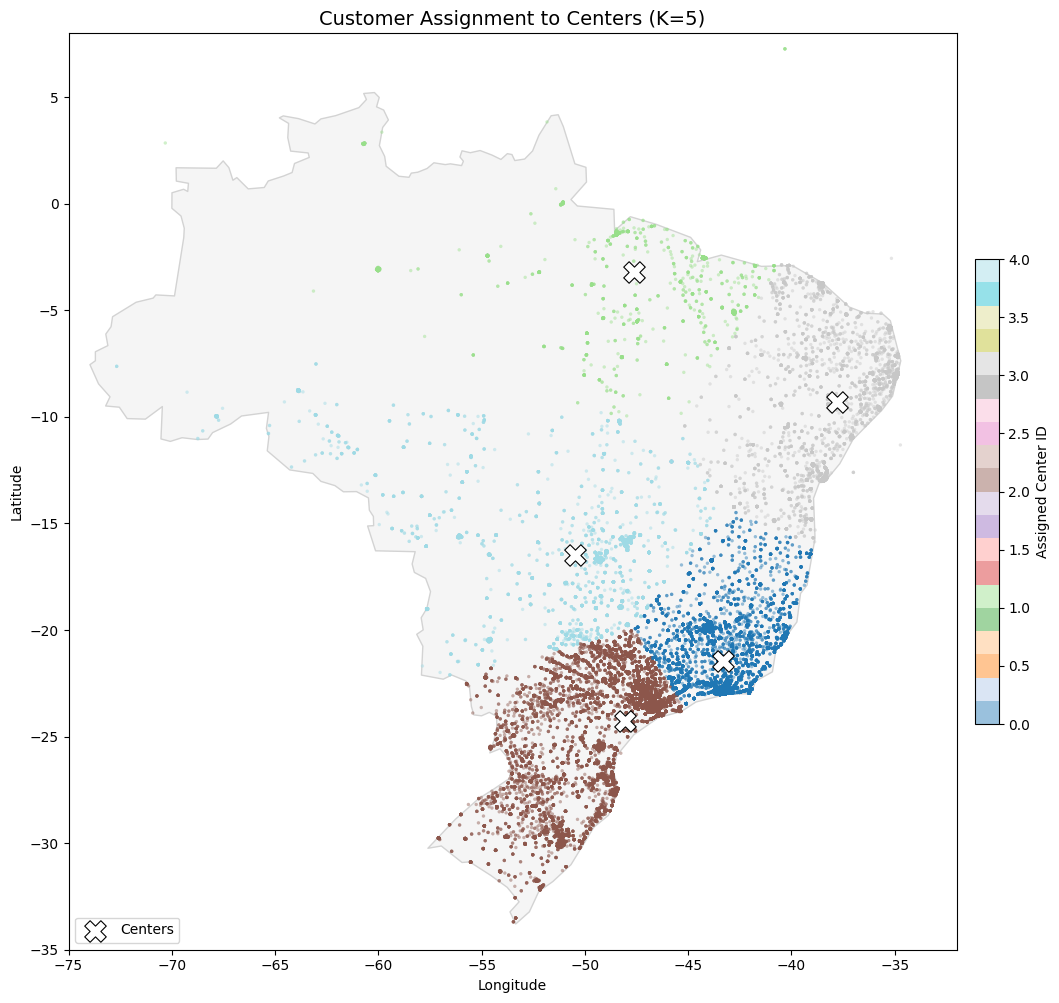

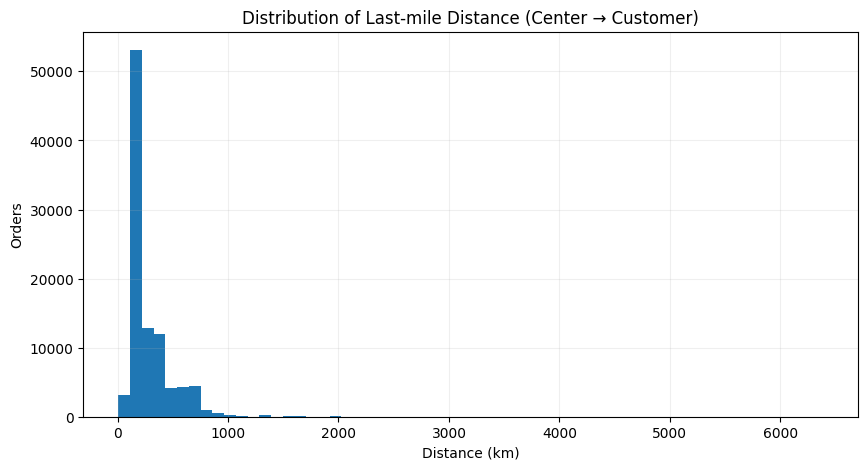

   assigned_center_id  orders  avg_lastmile_km       p200       p500
2                   2   53650       272.399120  61.278658  87.041938
0                   0   25053       205.331644  71.260927  97.193949
3                   3    7605       407.138465   8.783695  77.041420
4                   4    7531       426.450967  17.076086  75.063073
1                   1    2372       475.679536   3.583474  62.352445


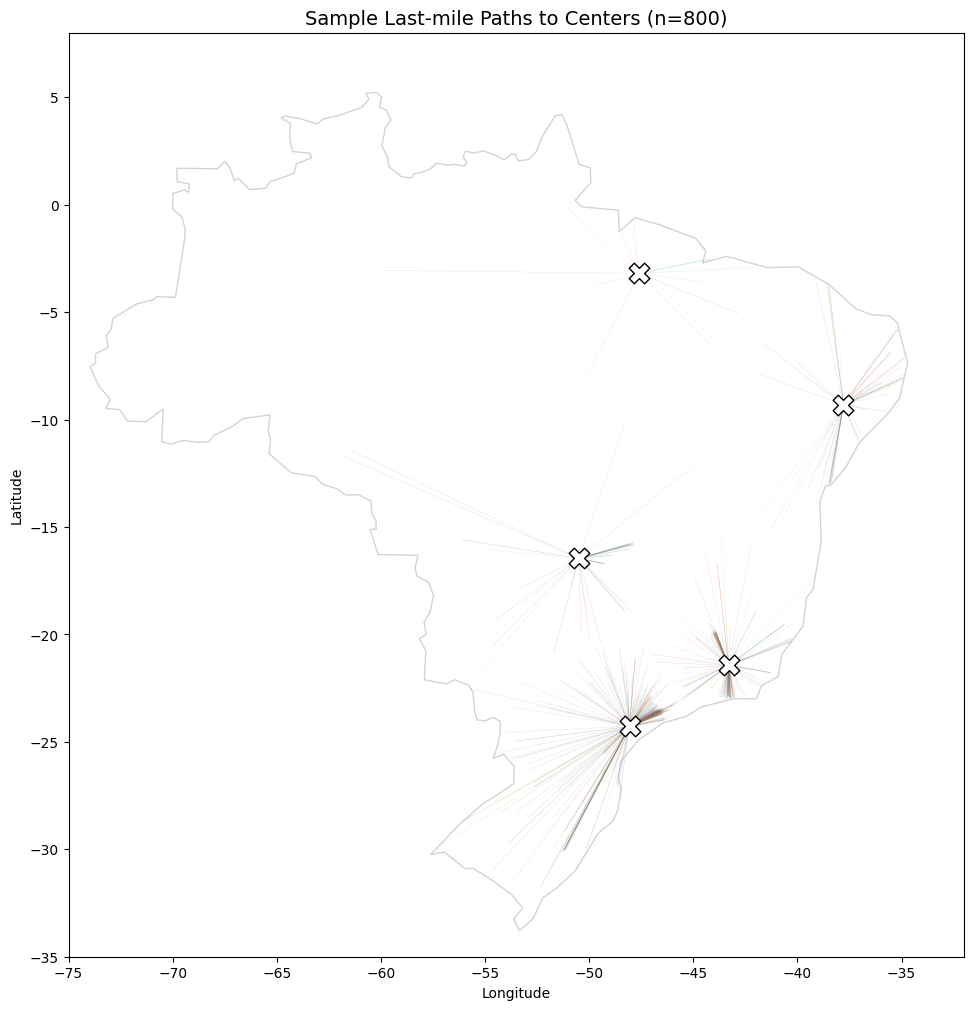

In [ ]:
# 1) 브라질 배경 지도(있으면 사용)
has_brazil = False
try:
    brazil  # 이미 로드돼 있으면 사용
    has_brazil = True
except NameError:
    has_brazil = False

# 2) 시각화: 지도 위에 센터 + 고객(센터 할당 색)
K = len(centers)
cent_lat, cent_lng = centers[:,0], centers[:,1]

fig, ax = plt.subplots(figsize=(12, 12))
if has_brazil:
    try:
        brazil.plot(ax=ax, color="#F5F5F5", edgecolor="lightgray")
    except Exception:
        pass

# 고객 위치 색상: assigned_center_id 기준
# 과도한 점 겹침을 줄이려고 alpha 살짝 낮춤
scatter = ax.scatter(
    df['geolocation_lng_cust'], df['geolocation_lat_cust'],
    c=df['assigned_center_id'], cmap='tab20',  # K가 20 넘어가면 tab20 반복됨
    s=6, alpha=0.45, linewidths=0
)

# 센터 위치: 큰 X 마커
ax.scatter(
    cent_lng, cent_lat,
    s=240, marker="X", edgecolor="black", linewidths=0.8,
    facecolor="white", label="Centers", zorder=3
)

ax.set_title(f"Customer Assignment to Centers (K={K})", fontsize=14)
ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")
ax.set_xlim(-75, -32); ax.set_ylim(-35, 8)
ax.legend(loc="lower left")

# 컬러바(센터 ID)
cbar = plt.colorbar(scatter, ax=ax, fraction=0.025, pad=0.02)
cbar.set_label("Assigned Center ID")

plt.show()

# 3) 라스트마일 거리 분포(히스토그램)
fig2, ax2 = plt.subplots(figsize=(10,5))
ax2.hist(df['lastmile_km'], bins=60)
ax2.set_title("Distribution of Last-mile Distance (Center → Customer)")
ax2.set_xlabel("Distance (km)")
ax2.set_ylabel("Orders")
ax2.grid(alpha=0.2)
plt.show()

# 4) 클러스터별 라스트마일 요약 테이블
cluster_summary = (
    df.groupby('assigned_center_id', as_index=False)
      .agg(
          orders=('order_id','nunique'),
          avg_lastmile_km=('lastmile_km','mean'),
          p200=('lastmile_km', lambda s: (s<=200).mean()*100),
          p500=('lastmile_km', lambda s: (s<=500).mean()*100),
      )
      .sort_values('orders', ascending=False)
)
print(cluster_summary.head(20))

# 5) 샘플 경로 라인(시각적 참고용, 일부만)
# 너무 빽빽하니 n 샘플만 그리기. 브라질 경계가 있으면 위에 얹음.
n = 800  # 필요시 줄이거나 늘려
idx = np.random.RandomState(42).choice(df.index, size=min(n, len(df)), replace=False)

fig3, ax3 = plt.subplots(figsize=(12, 12))
if has_brazil:
    try:
        brazil.plot(ax=ax3, color="#FFFFFF", edgecolor="lightgray")
    except Exception:
        pass

# 샘플 고객-센터 라인
for i in idx:
    cid = int(df.loc[i, 'assigned_center_id'])
    ax3.plot(
        [df.loc[i,'geolocation_lng_cust'], cent_lng[cid]],
        [df.loc[i,'geolocation_lat_cust'], cent_lat[cid]],
        linewidth=0.3, alpha=0.2
    )

# 센터 포인트 강조
ax3.scatter(cent_lng, cent_lat, s=220, marker="X", edgecolor="black", facecolor="white", zorder=3)
ax3.set_title(f"Sample Last-mile Paths to Centers (n={len(idx)})", fontsize=14)
ax3.set_xlim(-75, -32); ax3.set_ylim(-35, 8)
ax3.set_xlabel("Longitude"); ax3.set_ylabel("Latitude")
plt.show()

### 사후 평가

In [ ]:
def evaluate_lastmile_with_expected(df: pd.DataFrame, sla: int = 10):
    out = {}
    df = df.copy()

    # 1) 라스트마일 거리 비교
    mask = df[['dist_direct_km','lastmile_km','delivery_time_days']].notna().all(axis=1)
    if mask.sum() == 0:
        raise ValueError("라스트마일/실제 배송일수 유효 데이터가 없습니다.")

    lm_old_mean = df.loc[mask, 'dist_direct_km'].mean()
    lm_new_mean = df.loc[mask, 'lastmile_km'].mean()
    out['라스트마일_평균_old_km'] = lm_old_mean
    out['라스트마일_평균_new_km'] = lm_new_mean
    out['라스트마일_개선율'] = 1 - (lm_new_mean / lm_old_mean)


    # 2) 관측 정시율 (현재 기준)
    if 'on_time_flag' in df.columns:
        out['관측_정시율_현재'] = float(df['on_time_flag'].mean())


    # 3) 거리 → 배송일 회귀 모델 적합
    X = df.loc[mask, ['dist_direct_km']].astype(float)
    y = df.loc[mask, 'delivery_time_days'].astype(float)

    model = LinearRegression().fit(X, y)
    a, b = model.intercept_, model.coef_[0]
    out['회귀식'] = f"delivery_days ≈ {a:.3f} + {b:.5f}*distance_km"


    # 4) 예측 배송일 old/new
    df['pred_days_old'] = a + b * df['dist_direct_km']
    df['pred_days_new'] = a + b * df['lastmile_km']


    # 5) SLA 기준 정시율 추정
    old_rate = (df['pred_days_old'] <= sla).mean()
    new_rate = (df['pred_days_new'] <= sla).mean()
    out[f'예상정시율_old(≤{sla}일)'] = old_rate
    out[f'예상정시율_new(≤{sla}일)'] = new_rate
    out[f'예상정시율_개선(절대)'] = new_rate - old_rate

    return out

# example
res = evaluate_lastmile_with_expected(df, sla=10)
for k, v in res.items():
    print(f"{k}: {v}")

라스트마일_평균_old_km: 600.7607496019624
라스트마일_평균_new_km: 282.6279366479282
라스트마일_개선율: 0.5295499300924952
관측_정시율_현재: 0.9323362193512177
회귀식: delivery_days ≈ 8.281 + 0.00633*distance_km
예상정시율_old(≤10일): 0.2963486503622247
예상정시율_new(≤10일): 0.6540312438286683
예상정시율_개선(절대): 0.3576825934664436


In [ ]:
def expected_ontime_table(df: pd.DataFrame, sla_list=(10, 15)):
    """
    라스트마일 기준으로 예상 정시율(old/new)을 SLA 여러 값에 대해 동시에 계산.
    - old: dist_direct_km (직배송 라스트마일)
    - new: lastmile_km (센터→고객 라스트마일)
    - 회귀식: delivery_time_days ~ dist_direct_km (과거 실적 기반)
    반환: DataFrame [SLA, old_rate, new_rate, delta_pp]
    """
    d = df.copy()

    # 유효 표본(회귀 적합용): 거리/일수 결측 제거
    mask_fit = d[['dist_direct_km', 'delivery_time_days']].notna().all(axis=1)
    if mask_fit.sum() < 10:
        raise ValueError(f"회귀 적합 표본이 부족합니다: {mask_fit.sum()}행")

    X = d.loc[mask_fit, ['dist_direct_km']].astype(float)
    y = d.loc[mask_fit, 'delivery_time_days'].astype(float)

    # 선형회귀 적합 (거리→일수)
    lm = LinearRegression().fit(X, y)
    a, b = float(lm.intercept_), float(lm.coef_[0])
    print(f"[회귀식] delivery_days ≈ {a:.3f} + {b:.5f} * distance_km")

    # 예측 배송일 (라스트마일 old/new)
    # 예측 대상 유효 행(라스트마일 비교 가능)
    mask_eval = d[['dist_direct_km', 'lastmile_km']].notna().all(axis=1)
    if mask_eval.sum() == 0:
        raise ValueError("라스트마일 비교 가능한 행이 없습니다.")

    d.loc[mask_eval, 'pred_days_old'] = a + b * d.loc[mask_eval, 'dist_direct_km'].astype(float)
    d.loc[mask_eval, 'pred_days_new'] = a + b * d.loc[mask_eval, 'lastmile_km'].astype(float)

    # SLA별 예상 정시율 표 생성
    rows = []
    for sla in sla_list:
        old_rate = (d.loc[mask_eval, 'pred_days_old'] <= sla).mean()
        new_rate = (d.loc[mask_eval, 'pred_days_new'] <= sla).mean()
        rows.append({
            'SLA(일)': sla,
            '예상정시율_old': old_rate,
            '예상정시율_new': new_rate,
            '개선폭(절대%p)': new_rate - old_rate
        })

    # 참고로 라스트마일 평균 개선도 같이 보여주기(선택)
    lm_old_mean = d.loc[mask_eval, 'dist_direct_km'].mean()
    lm_new_mean = d.loc[mask_eval, 'lastmile_km'].mean()
    lm_impr = 1 - (lm_new_mean / lm_old_mean)
    print(f"[라스트마일 평균] old={lm_old_mean:.1f}km, new={lm_new_mean:.1f}km, 개선율={lm_impr:.3f}")

    return pd.DataFrame(rows).sort_values('SLA(일)').reset_index(drop=True)

# example
table = expected_ontime_table(df, sla_list=(10, 15))
print(table)

[회귀식] delivery_days ≈ 8.281 + 0.00633 * distance_km
[라스트마일 평균] old=600.8km, new=282.6km, 개선율=0.530
   SLA(일)  예상정시율_old  예상정시율_new  개선폭(절대%p)
0      10   0.297003   0.654038   0.357035
1      15   0.849936   0.993719   0.143783


#### 센터 배치 사후 평가 (라스트마일 기준)

왜 사후 평가를 하는가?
K-means 같은 클러스터링은 기본적으로 **거리 최소화**만 고려하기 때문에  
직접적으로 “고객 경험이 얼마나 개선되는가”를 알려주지는 않습니다.  
따라서 센터 위치를 뽑은 이후에는 **사후 평가(Post-hoc Evaluation)** 를 통해:

- 총 물류 거리(특히 라스트마일) 감소율
- 거리→배송일수 관계를 이용한 **예상 배송일수 개선**
- SLA(서비스 수준 약속, 며칠 이내 도착) 기준 충족률 개선
- 정시율(온타임 비율)의 변화

를 수치로 확인해야 합니다.  
즉, 단순히 센터 위치를 뽑는 것에 그치지 않고,  
**“이 배치가 실제로 고객 체감 품질을 얼마나 끌어올릴 수 있나?”** 를 정량적으로 보여주는 단계가 필요합니다.

---

이번 분석 결과 요약
- **회귀식 (거리→배송일수)**  
  `delivery_days ≈ 8.281 + 0.00633 * distance_km`  
  → 기본 리드타임이 약 8.3일, 거리가 1000km 늘면 약 6.3일 더 걸리는 패턴.

- **라스트마일 평균**  
  - 직배송(과거): 약 600.8km  
  - 센터 배치(신규): 약 282.6km  
  - **평균 라스트마일 거리 53% 감소**

- **예상 정시율 (SLA 기준)**  
  - SLA=10일  
    - old: 29.7% → new: 65.4%  
    - **+35.7%p 개선**  
  - SLA=15일  
    - old: 84.9% → new: 99.4%  
    - **+14.4%p 개선**

---

해석
- 센터 배치를 통해 고객에게 더 가까운 위치에서 배송이 가능해졌고,  
  평균 라스트마일 거리가 절반 이하로 줄었습니다.  
- 거리–일수 회귀식을 적용해 시뮬레이션한 결과,  
  **예상 배송일이 단축되고 정시율(SLA 충족률)도 크게 개선**되는 것으로 나타났습니다.  
- 특히 SLA=10일 같은 비교적 엄격한 기준에서는 **정시율이 약 30% → 65%로 2배 이상 향상**됩니다.  
- SLA=15일처럼 느슨한 기준에서도 거의 모든 주문이 정시에 도착하는 수준(99% 이상)까지 개선됩니다.  

👉 결론적으로, 단순 거리 기반 클러스터링으로 센터를 배치했더라도  
사후 평가를 통해 **“이 배치가 실제로 고객 경험 품질을 어떻게 끌어올리는지”**를 수치로 확인할 수 있었고,  
센터 도입 효과가 상당히 긍정적임을 알 수 있습니다.